In [207]:
import numpy as np
import os
from typing import List, Dict, Tuple, Literal
from policies import Policy
from collections import deque, OrderedDict

from consts import DATA_REC_SIM_EMBEDDS

import gymnasium as gym
from gymnasium import spaces

# Pre-defined boredom types and click models
_BOREDOM_TYPES = Literal["user_tloi", "user_car"]
_CLICK_MODELS = Literal["tdPBM", "mixPBM"]
_DATASET_FORMATS = Literal["dict", "sb3_rollout", "sb3_replay"]


# Load the .env file
load_dotenv()

# Accessing variables
num_items = 10000
num_users = os.getenv('NUM_USERS')
num_actions = 100
slate_size = int(os.getenv('SLATE_SIZE'))
episode_length = 50
env_alpha = float(os.getenv('ENV_ALPHA'))
num_topics = int(os.getenv('NUM_TOPICS'))
slate_size = int(os.getenv('SLATE_SIZE'))
env_alpha = os.getenv('ENV_ALPHA')
env_propensities = os.getenv('ENV_PROPENSITIES')
env_offset = os.getenv('ENV_OFFSET')
env_slope = os.getenv('ENV_SLOPE')
env_omega = os.getenv('ENV_OMEGA')
recent_items_maxlen = int(os.getenv('RECENT_ITEMS_MAXLEN'))
boredom_threshold = float(os.getenv('BOREDOM_THRESHOLD'))
boredom_moving_window = int(os.getenv('BOREDOM_MOVING_WINDOW'))
env_embedds = os.getenv('ENV_EMBEDDS')
click_model = os.getenv('CLICK_MODEL')
rel_threshold = os.getenv('REL_THRESHOLD')
diversity_penalty = os.getenv('DIVERSITY_PENALTY')
diversity_threshold = os.getenv('DIVERSITY_THRESHOLD')
click_prop = float(os.getenv('CLICK_PROP'))
boredom_type = os.getenv('BOREDOM_TYPE')
rel_penalty = os.getenv('REL_PENALTY')
condition = True




In [208]:
class Sardine(gym.Env):
    '''
        a Simulator for Automated Recommendation in Dynamic and INteractive Environments
    '''
    metadata = {"render_modes": ["human"]}



    def __init__(self, num_items : int, slate_size : int, num_topics : int, episode_length : int, 
                env_alpha : float, env_propensities : List[float], env_offset : float, env_slope: float, env_omega : float, 
                recent_items_maxlen : int, boredom_threshold : int, boredom_moving_window : int, 
                env_embedds : str, click_model : _CLICK_MODELS, rel_threshold : float, 
                diversity_penalty : float, diversity_threshold : int, click_prop : float,
                boredom_type : _BOREDOM_TYPES, rel_penalty : bool, condition: bool, render_mode=None, **kwargs):
        super().__init__()

        ### General parameters of the environment
        self.num_items = num_items
        self.item_ids = np.arange(self.num_items)  # Simple sequential IDs
        self.item_occurrences = np.zeros(self.num_items, dtype=int)
        self.item_clicks = np.zeros(self.num_items, dtype=int)
        self.num_topics = num_topics
        self.slate_size = slate_size
        self.H = episode_length
        self.condition = condition
        ### Observation and action spaces
        self.observation_space = spaces.Dict(
            {
                "slate": spaces.MultiDiscrete([num_items] * slate_size),
                "clicks": spaces.MultiBinary(n = slate_size),
                "hist": spaces.Box(low = 0, high = 1, shape=(num_topics,), dtype=np.float32)
            }
        )
        self.action_space = spaces.MultiDiscrete([num_items] * slate_size)

        ### Click model
        self._set_propensities(click_model, click_prop, env_propensities, env_alpha)

        ### User preference model
        self.offset = env_offset
        self.slope = env_slope
        self.omega = float(env_omega)
        self.rel_threshold = float(rel_threshold)
        self.diversity_penalty = float(diversity_penalty)
        self.diversity_threshold = diversity_threshold

        ### Boredom model
        self.recent_items_maxlen = recent_items_maxlen
        self.boredom_thresh = boredom_threshold
        self.boredom_moving_window = boredom_moving_window

        self.rel_penalty = rel_penalty
        self.boredom_type = boredom_type

        ### Item generation
        self._init_item_embeddings(env_embedds)
        self._set_topic_for_items()

    def get_item_embeddings(self):
        """
        Returns a copy of the item embeddings array.

        Returns:
            np.ndarray: The item embeddings.
        """
        return np.copy(self.item_embedd)

    def get_item_occurrences(self):
        return self.item_occurrences

    def get_item_clicks(self):
        return self.item_clicks

    def _set_propensities(self, click_model: str, click_prop : float = None, env_propensities : List[float] = None, env_alpha : float = 1.0):
        '''
            Setting click propensities of the PBM click model.
        '''
        self.alpha = float(env_alpha) # Discount applied from relevance to attractiveness

        if click_model=="tdPBM":
            self.propensities = np.power(click_prop, np.arange(self.slate_size))
        elif click_model=="mixPBM":
            probs = [0.5, 0.5]
            props = np.power(click_prop, np.arange(self.slate_size))
            #props = gammas[:, np.newaxis].repeat(self.slate_size, axis = 1)
            self.propensities = probs[0] * props + probs[1] * np.flip(props, axis = 0)
        else:
            self.propensities = env_propensities

    def _init_item_embeddings(self, env_embedds : str):
        """
        Initializes item embeddings
        """
        if env_embedds is None: # Generate new item embeddings
            # Item embeddings with only a certain number of topics
            # Values for other topics are completely zeroed out
            num_topics_per_item = 2 # Average number of topics per item
            self.item_embedd = np.random.rand(self.num_items, self.num_topics)

            # Create a boolean tensor of shape [num_items, num_topics] filled with False values
            mask = np.zeros((self.num_items, self.num_topics), dtype=bool)
            # Force items to have between 2 and 3 topics
            # Since all items which have single topics are identical to each other (i.e., same one-hot vector),
            # Utilize items between 2 and 3 topics
            num_true_values = np.random.randint(num_topics_per_item, num_topics_per_item + 2, (self.num_items,))
            for i in range(self.num_items):
                indices = np.random.permutation(self.num_topics)[:num_true_values[i]]
                mask[i, indices] = True
            self.item_embedd *= mask
            embedd_norm = np.linalg.norm(self.item_embedd, axis = -1)

            self.item_embedd /= embedd_norm[:, np.newaxis]
            np.save(os.path.join("embeddings", "item_embeddings"), self.item_embedd)
            np.savetxt("DEV_item_embeddings.csv", self.item_embedd, delimiter=",")
        else: # Load existing item embeddings
            self.item_embedd = np.load(os.path.join(DATA_REC_SIM_EMBEDDS, env_embedds))

    def _set_topic_for_items(self):
        """
        Sets main topic for each item
        """
        # with m > 1:
        self.item_comp = np.argmax(self.item_embedd, axis = 1)
        self.max_score = np.max(np.linalg.norm(self.item_embedd, axis = 1))

    def _compute_clicks(self, rels : np.ndarray, comps : np.ndarray) -> np.ndarray:
        '''
            PBM click model
        '''
        attr = self.alpha * rels
        if np.max(np.unique(comps, return_counts = True)[1]) >= self.diversity_threshold:
            attr /= self.diversity_penalty ### When too many similar are in the slate, the overall attractiveness of the slate decreases.
        click_probs = attr * self.propensities
        clicks = self.np_random.binomial(n = 1, p = click_probs)
        return clicks

    def _reset_user_embedds(self):
        '''
            Resets the user embedding
        '''
        # User embedding where users are only interested in a certain number of topics
        # Values for other topics are completely zeroed out

        num_topics_per_user = 4 # Average number of topics per user
        threshold = 1 - float(num_topics_per_user) / self.num_topics
        self.user_embedd = self.np_random.uniform(size = (self.num_topics,))
        mask = self.np_random.uniform(size = (self.num_topics,)) > threshold
        while sum(mask) <= num_topics_per_user - 2 or sum(mask) >= num_topics_per_user + 2: # Force users to have between 3 and 5 topics
            mask = self.np_random.uniform(size = (self.num_topics,)) > threshold
        self.user_embedd *= mask
        embedd_norm = np.linalg.norm(self.user_embedd)
        self.user_embedd /= embedd_norm

    def _initial_reco(self):
        """
        Initial slate recommendation with random items
        """
        return self.np_random.integers(low = 0, high = self.item_embedd.shape[0], size = (self.slate_size,))

    def reset(self, seed = None, options = None) -> Tuple[Dict, Dict]:
        '''
            The initial ranker returns the most qualitative document in each topic (or the 10 first topics, or multiple top_docs per topic)
        '''
        super().reset(seed=seed)

        self.boredom_counter = 0
        self.t = 0  # Index of the trajectory-wide timestep
        self.clicked_items = deque([], self.recent_items_maxlen)
        self.clicked_item_topics = deque([], self.recent_items_maxlen)
        self.clicked_step = deque([], self.recent_items_maxlen)
        self.all_clicked_items = []
        self.bored = np.zeros(self.num_topics, dtype = bool)
        self.bored_timeout = self.boredom_moving_window * np.ones(self.num_topics, dtype = int)

        ## User embeddings
        self._reset_user_embedds()

        ## Initial recommendation
        slate = self._initial_reco()

        ## Compute relevances
        slate_embedd = self.item_embedd[slate]    # slate_size, num_topics
        score = slate_embedd @ self.user_embedd   # slate_size
        norm_score = score / self.max_score # Normalize score
        if self.rel_threshold is None:
            relevances = 1 / (1 + np.exp(-(norm_score - self.offset) * self.slope))    ## Rescale relevance
        else:
            relevances = np.where(norm_score > self.rel_threshold, 1, 0)

        ## First interaction
        clicks = self._compute_clicks(relevances, self.item_comp[slate])
        clicked_items = np.where(clicks)[0]
        self.clicked_items.extend(slate[clicked_items])
        self.clicked_item_topics.extend(self.item_comp[slate[clicked_items]])
        self.clicked_step.extend(self.t * np.ones_like(clicked_items))
        self.all_clicked_items.extend(slate[clicked_items])

        ## Update the user state for the next step
        user_state = self._update_user_state(slate, clicked_items)

        info = {'user_state' : user_state, 'terminated' : False, 'clicks' : clicks}
        obs = {'slate' : slate, 'clicks' : clicks, 'hist' : self.norm_recent_topics_hist}
        return obs, info

    def get_st_oracle_slate(self, slate, relevances):
        """
        Short term oracle for a given user embedding.
        Completes a slate whose missing elements are replaced with -1
        """
        ind = np.argpartition(relevances, - self.slate_size)[- self.slate_size:]
        topk_relevances = np.argsort(relevances[ind])
        oracle_slate = ind[np.flip(topk_relevances)]
        antioracle_slate = ind[topk_relevances]

        return np.where(slate == -1, oracle_slate, np.where(slate == -2, antioracle_slate, slate))

    def _adjust_user_embedds(self, cur_u_embedd, bored_topics):
        # Boredom factor influences the user embeddings
        if self.boredom_type == "user_tloi": # Temporary loss-of-interest boredom: boring topic components are zeroed out
            ### Set bored component to 0
            for bt in bored_topics:
                cur_u_embedd[bt] = 0.0

        if self.boredom_type == "user_car": # Churn-and-return boredom: all components are zeroed out
            ### Set user embedding to 0 if there is any boredom
            if (self.bored == True).sum() > 0:
                cur_u_embedd[:] = 0.0

        return cur_u_embedd

    def _clicked_item_influence(self, slate, clicked_items):
        """
        Influence the user embedding with the clicked items in the slate
        """
        if len(slate[clicked_items]) > 0:
            # Compute the average of item embeddings for the clicked items in the slate
            slate_item_embedd = np.mean([self.item_embedd[it] for it in slate[clicked_items]])

            self.user_embedd = self.omega * self.user_embedd + (1 - self.omega) * slate_item_embedd
            embedd_norm = np.linalg.norm(self.user_embedd)
            self.user_embedd /= embedd_norm

    def _update_user_state(self, slate, clicked_items):
        ## Increment time step
        self.t += 1

        ## We remove old clicks from boredom "log"
        while len(self.clicked_step) > 0 and self.clicked_step[0] < self.t - self.boredom_moving_window:
            self.clicked_item_topics.popleft()
            self.clicked_step.popleft()
        self.all_clicked_items.extend(slate[clicked_items])

        ## Update bored_timeout in the next step
        self.bored_timeout -= self.bored.astype(int) # Remove one to timeout for bored topics
        self.bored = self.bored & (self.bored_timeout != 0) # "Unbore" timed out components
        self.bored_timeout[self.bored == False] = self.boredom_moving_window # Reset timer for "unbored" components

        ## Bored anytime recently items from one topic have been clicked more than boredom_threshold
        if len(self.clicked_item_topics) > 0:
            recent_topics = np.concatenate([it[np.newaxis] for it in self.clicked_item_topics])
            recent_topics_hist = np.bincount(recent_topics, minlength = self.num_topics)
            bored_topics = np.arange(self.num_topics)[recent_topics_hist >= self.boredom_thresh]
            ## Then, boredom is triggered for the topics on which have been clicked more than boredom_thresh
            self.bored[bored_topics] = True
        else:
            ## No clicked items in recent history
            recent_topics_hist = np.zeros(self.num_topics)
        bored_topics = np.nonzero(self.bored)[0]

        ## Let clicked items influence user behavior
        self._clicked_item_influence(slate, clicked_items)

        ## Apply boredom and short-term interest to the user embedding
        self.cur_user_embedd = self._adjust_user_embedds(self.user_embedd.copy(), bored_topics)

        ## Define user state and normalize vectors between 0 and 1
        self.norm_recent_topics_hist = np.clip(recent_topics_hist / self.boredom_thresh, 0, 1).astype('float32') # Clip between 0 and 1
        norm_bored_timeout = self.bored_timeout / self.boredom_moving_window
        bored = self.bored.astype(np.float32)
        user_state = np.concatenate([self.cur_user_embedd, self.norm_recent_topics_hist, norm_bored_timeout], axis=0, dtype=np.float32)
        #user_state = np.concatenate([self.user_embedd, self.norm_recent_topics_hist, norm_bored_timeout], axis=0, dtype=np.float32)
        #user_state = np.concatenate([self.cur_user_embedd, self.norm_recent_topics_hist, norm_bored_timeout, bored], axis=0, dtype=np.float32)

        return user_state

    def step(self, slate, condition, alpha=1, beta=0, gamma=1) -> Tuple[Dict, float, bool, bool, Dict]:
        '''
            Simulates user interaction.
        '''
        

        ## Compute relevances
        scores = self.item_embedd @ self.cur_user_embedd

        norm_scores = scores / self.max_score # Normalize score
        if self.rel_threshold is None:
            relevances = 1 / (1 + np.exp(-(norm_scores - self.offset) * self.slope))    ## Rescale relevance
        else:
            relevances = np.where(norm_scores > self.rel_threshold, 1, 0)

        ## Reduce overall relevance score if user is bored => Reflects interest in platform
        if self.rel_penalty:
            relevances *= (0.5 ** (self.bored == True).sum())

        # Short Time Oracle acts as greedily as possible.
        st_oracle = (-1 in slate) or (-2 in slate)
        if st_oracle:
            slate = self.get_st_oracle_slate(slate, relevances)
        relevances = relevances[slate]

        info = {}
        info["slate"] = slate
        info["slate_components"] = self.item_comp[slate]
        info["scores"] = norm_scores[slate]
        info["bored"] = self.bored
        info["relevances"] = relevances

        ## Interaction
        clicks = self._compute_clicks(relevances, self.item_comp[slate])
        clicked_items = np.where(clicks)[0]
        self.clicked_items.extend(slate[clicked_items])
        self.clicked_item_topics.extend(self.item_comp[slate[clicked_items]])
        self.clicked_step.extend(self.t * np.ones_like(clicked_items))
        info["clicks"] = clicks


        # Update occurrences
        for item_id in slate:
            self.item_occurrences[item_id] += 1

        # Update clicks
        for idx, click in enumerate(clicks):
            if click == 1:
                self.item_clicks[slate[idx]] += 1
                                    


        # print(action)

        ## Update the user state for the next step
        user_state = self._update_user_state(slate, clicked_items)
        info["user_state"] = user_state

        ## Set terminated and return
        if self.t > self.H:
            terminated = True
            info["terminated"] = True
        else:
            terminated = False
            info["terminated"] = False

        obs = {'slate' : slate, 'clicks' : clicks, 'hist' : self.norm_recent_topics_hist}

        if not condition:
            reward = np.sum(clicks)
            r_acc = 0
            r_div = 0
            r_nov = 0
        else:
            """
                TODO : Implement a reward function for the conditional case
            """
            # print("clicks",clicks)
            # print(sum(clicks))
            r_acc = np.sum(clicks)

            def intra_slate_dissimilarity(slate: np.ndarray):
                """
                    TODO: Implement intra-slate dissimilarity metric.
                """
                p = slate.shape[0]

                # hamming distance 
                def hamming_distance(item_1, item_2):
                    return np.sum(item_1 != item_2)
                
                r_div = (p * (p - 1)) / 2 * np.sum([hamming_distance(slate[i], slate[j]) for i in range(p) for j in range(i + 1, p)])
                # print(r_div)

                return r_div

            r_div = intra_slate_dissimilarity(slate)

            def novelty(slate):
                """
                    TODO: Implement novelty metric.
                """
                items = self.item_occurrences
                sorted_indices = sorted(range(len(items)), key=lambda idx: items[idx])
                

                r_nov = 0
                for item in slate: 
                    if sorted_indices.index(item)/len(sorted_indices) > 0.1:
                        r_nov += 1/len(slate)

                return 0

            r_nov = novelty(slate)

            reward = (alpha*r_acc + beta*r_div + gamma*r_nov)/(alpha + beta + gamma)
        # print("reward", reward)

        return obs, reward, terminated, False, info, r_acc, r_div, r_nov

    def _append_dict_values(self, old_dict, append_dict):
        for k in old_dict.keys():
            if isinstance(old_dict[k], dict):
                self._append_dict_values(old_dict[k], append_dict[k])
                continue
            old_dict[k].append(append_dict[k])
        return

    def _to_numpy(self, ep_dict):
        for k in ep_dict.keys():
            if isinstance(ep_dict[k], dict):
                self._to_numpy(ep_dict[k])
                continue
            ep_dict[k] = np.array(ep_dict[k])
        return

    def generate_dataset(self, n_users : int, policy: Policy, seed: int = None, dataset_type: _DATASET_FORMATS = "dict"):
        """
            Generate a dataset of trajectories from the environment.
            If dataset_type in ["sb3_replay", sb3_rollout"], dataset will be a
            Replay/Rollout Buffer as in Stable Baselines 3 (requires PyTorch).
            Otherwise it is a dictionary of dictionaries.
        """
        dataset = OrderedDict()
        observation, _ = self.reset(seed = seed)
        self.action_space.seed(seed)
        u = 0
        if dataset_type == "sb3_rollout":
            try:
                import torch
            except ModuleNotFoundError:
                raise ModuleNotFoundError("You need to install pytorch to generate a dataset in DB3 format.")
            from .buffer import DictRolloutBuffer
            dataset = DictRolloutBuffer(n_users * self.H,
                self.observation_space,
                self.action_space,
                device = "cpu", gamma = 1.0)
            ep_starts = np.array(True)
        elif dataset_type == "sb3_replay":
            try:
                import torch
            except ModuleNotFoundError:
                raise ModuleNotFoundError("You need to install pytorch to generate a dataset in DB3 format.")
            from .buffer import DictReplayBuffer
            dataset = DictReplayBuffer(n_users * self.H,
                self.observation_space,
                self.action_space,
                device = "cpu",
                handle_timeout_termination = False)
        else:
            episode_dict = {"observation": {"slate": [], "clicks": [], "hist": []},
                            "action": [],
                            "reward": [],
                            "r_acc": [],
                            "r_div": [],
                            "r_nov": []}
        while u < n_users:
            # print("observation", observation)
            action = policy.get_action(observation)
            # print("action",action)
            next_obs, reward, terminated, truncated, info, r_acc, r_div, r_nov = self.step(action, condition=self.condition)
            done = terminated or truncated

            if dataset_type == "sb3_rollout":
                dataset.add(observation, info["slate"], reward, ep_starts, torch.zeros(1), torch.ones(1))
                ep_starts = np.array(done)
            elif dataset_type == "sb3_replay":
                dataset.add(observation, next_obs, info["slate"], reward, done, None)
            else:
                self._append_dict_values(episode_dict, {"observation": observation, "action": info["slate"], "reward": reward, "r_acc": r_acc, "r_div": r_div, "r_nov": r_nov})

            if done:
                observation, _ = self.reset()
                if dataset_type == "dict":
                    self._to_numpy(episode_dict)
                    dataset[u] = episode_dict
                    episode_dict = {"observation": {"slate": [], "clicks": [], "hist": []},
                            "action": [],
                            "reward": [],
                            "r_acc": [],
                            "r_div": [],
                            "r_nov": []}
                u += 1
            else:
                observation = next_obs
                # print(observation)
        if dataset_type == "sb3_rollout":
            dataset.compute_returns_and_advantage(torch.zeros(1), np.array(True))
        return dataset
    

In [213]:
from dotenv import load_dotenv
import os
from policies import EpsilonGreedyOracle, EpsilonGreedyAntiOracle


# print(f"num_items: {num_items}, num_users: {num_users}, num_actions: {num_actions}, slate_size: {slate_size}")

env = Sardine(num_items=num_items, 
                  num_users=num_users, 
                  num_actions=num_actions, 
                  slate_size=slate_size, 
                  episode_length=episode_length,
                  seed=2024, 
                  num_topics=num_topics, 
                  env_alpha=env_alpha, 
                  env_propensities=env_propensities,
                  env_offset=env_offset, 
                  env_slope=env_slope,
                  env_omega=env_omega,
                  recent_items_maxlen=recent_items_maxlen,
                  boredom_threshold=boredom_threshold,
                  boredom_moving_window=boredom_moving_window,
                  env_embedds=env_embedds, 
                  click_model=click_model, 
                  rel_threshold=rel_threshold, 
                  diversity_penalty=diversity_penalty, 
                  diversity_threshold=int(diversity_threshold), 
                  click_prop=click_prop, 
                  boredom_type=boredom_type, 
                  condition = condition,
                  rel_penalty=rel_penalty,
                  )

occurrences = env.get_item_occurrences()
clicks = env.get_item_clicks()

# print(occurrences)
# print(clicks)

## Generate a dataset of 10 users with 50% random actions and 50% greedy actions
logging_policy = EpsilonGreedyAntiOracle(epsilon = 0.7, env = env, seed = 2024)
dataset = env.generate_dataset(n_users = 50, policy = logging_policy, seed = 2024, dataset_type="dict")
# env.get_item_embeddings()
# print("item_clicks", env.get_item_clicks(), "item_occurrences", env.get_item_occurrences())



In [214]:
print(dataset[0])

{'observation': {'slate': array([[3167, 2452, 6395, 1847, 2045, 9054, 8125, 5538, 9146, 3716],
       [4035, 7473, 3525, 2249, 2261, 1032, 9901,  535, 8015, 2227],
       [1805, 5565, 4984, 3164, 2177,  525, 2255, 2257, 7560, 2553],
       [6025, 3858, 1009, 2249, 8357, 7060, 2255, 5646, 1517, 6048],
       [4686, 8998, 2239, 4436, 2261, 8332, 5002, 2257, 6687, 8151],
       [2842, 6363, 2239, 2493, 9629, 6696, 1699, 6241, 3904, 4831],
       [ 505, 4518, 1271, 3410, 6907, 2285, 2844, 3874, 1763, 9272],
       [6463,  991, 3045, 2249, 2983, 8731,  515, 5477, 6291, 8133],
       [9826, 8049, 2034,  533, 2261, 9091, 2255, 7287, 4921, 1378],
       [6698, 3584, 2797, 4363,  599, 9523, 4381, 2257, 9666, 5790],
       [5206, 7826, 9122,   22, 3332, 1003, 3334, 5752, 6009, 1192],
       [ 952, 6704, 2509, 5823, 8259, 6502, 1704, 3335, 7817, 2004],
       [6584, 8942, 3337, 8241, 3332, 3925, 2139, 3335, 1731, 8603],
       [2601, 5317, 3337, 1674, 4763, 3333, 1462, 9220, 9656, 4791],
       [

In [215]:
cum_rewards = []
def add_previous_to_current(lst):
    for i in range(1, len(lst)):
        lst[i] += lst[i-1]
    return lst

for i in range(len(dataset)):
    print("user",i)
    # print("observation",dataset[i]['observation'])
    # print("action",dataset[i]['action'])


# Applying the function
    cum_reward = add_previous_to_current(dataset[i]['reward'])



    print("reward",list(dataset[i]['reward']))
    cum_rewards.append(cum_reward)
    # print("cumulative reward",np.sum(dataset[i]['reward']))
    # print("r_acc",dataset[i]['r_acc'])
    # print("r_div",dataset[i]['r_div'])
    # print("r_nov",dataset[i]['r_nov'])

# print("reward",dataset[1]['reward'])
# print("r_acc",dataset[1]['r_acc'])
# print("r_div",dataset[1]['r_div'])
# print("r_nov",dataset[1]['r_nov'])

user 0
reward [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.5, 8.0, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 13.0, 13.5, 14.0, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 19.0, 19.5, 20.0, 20.0, 21.0, 21.5, 22.0, 22.5, 23.0]
user 1
reward [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 9.5, 10.5, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.0, 14.5, 15.0, 15.5, 16.0, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0]
user 2
reward [0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5]
user 3
reward [0.5, 1.0, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0,

In [222]:
cum_rewards

arr = np.stack(cum_rewards)
# Calculate the mean along the first axis (across the corresponding indices of each array)
mean_cum_rewards = np.mean(arr, axis=0)
std_cum_rewards = np.std(arr, axis=0)
std_cum_rewards


array([0.28565714, 0.48414874, 0.58830264, 0.6514599 , 0.73654599,
       0.78797208, 0.83761566, 0.88408144, 0.8788629 , 0.90133235,
       0.90642154, 0.94281493, 0.94662559, 0.91241438, 0.93107465,
       0.95921843, 1.00702532, 1.01237345, 1.04407854, 1.07149428,
       1.07256701, 1.08282039, 1.13771701, 1.18743421, 1.24181319,
       1.25781557, 1.26095202, 1.27059041, 1.28378347, 1.27597022,
       1.30770792, 1.33356665, 1.32472639, 1.3360015 , 1.32227077,
       1.29880715, 1.29541499, 1.28767232, 1.29058126, 1.35133268,
       1.37437258, 1.37898513, 1.42902064, 1.44640935, 1.49963329,
       1.45      , 1.45794376, 1.47864803, 1.48462116, 1.47770092])

In [217]:
cum_rewards

[array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  1. ,  1.5,
         2. ,  2.5,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7.5,  8. ,
         8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 13. , 13.5,
        14. , 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 19. , 19.5, 20. ,
        20. , 21. , 21.5, 22. , 22.5, 23. ]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  4. ,  4.5,  5. ,  5.5,
         6. ,  6.5,  7. ,  7.5,  8. ,  9. ,  9.5, 10.5, 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14. , 14.5, 15. , 15.5, 16. , 17. , 17.5, 18. ,
        18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 23. , 23.5, 24. ,
        24.5, 25. , 25.5, 26. , 26.5, 27. ]),
 array([ 0.5,  1. ,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
         6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
        13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17.5, 18. , 18.5,
        19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. ,
        25. , 25.5, 

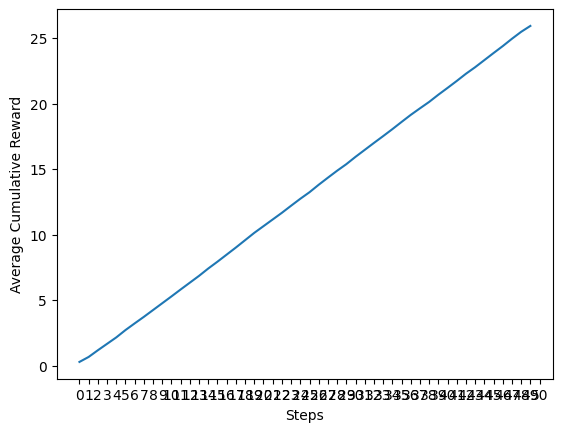

In [221]:
import matplotlib.pyplot as plt

plt.plot(mean_cum_rewards)
plt.ylabel('')

plt.xlabel('')
plt.xticks(np.arange(0, episode_length+1))

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


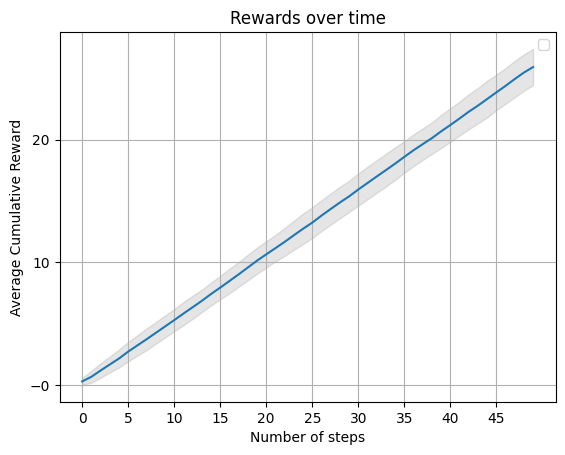

In [235]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'arr' is your array of data
data = np.mean(arr, axis=0)
# Assuming a constant error or you can have an array of errors specific for each point
errors = np.std(arr, axis=0)  # Example: Using standard deviation as error margins

# Number of data points
x_values = np.arange(len(data))

plt.plot(data)
plt.fill_between(x_values, data-errors, data + errors,
                 color='gray', alpha=0.2)

# Adding labels and title
plt.xlabel('Number of steps')
plt.ylabel('Average Cumulative Reward')
plt.title('Rewards over time')

# Adjusting x-axis and y-axis ticks if needed
plt.xticks(np.arange(start=0, stop=episode_length, step=5))
plt.yticks(np.arange(start=np.min(data-errors), stop=np.max(data+errors), step=10))

# Show plot with grid
plt.grid(True)
plt.legend()
plt.show()

In [199]:


for i in range(len(dataset)):
    print("action:",dataset[i]['action'][0])
    print("clicks:",dataset[i]['observation']['clicks'][0])

action: [55055 58849 59927 23036 23034 49033 78709 74961 31219 69253]
clicks: [0 0 0 0 0 0 0 0 0 0]


In [149]:
pip install matplotlib

173432.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 5.4 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.8 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [76]:
for i in range(len(dataset[0]['observation']['slate'])):
    print("action:",dataset[0]['action'][i])
    print("clicks:",dataset[0]['observation']['clicks'][i])

action: [99 61 15 77 58 68 82 34  1 42]
clicks: [0 0 0 0 0 0 0 0 0 0]
action: [48  0 33 38 35 78 49 31 30 85]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [58 34 99 32 35 49 73 90 30  6]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [63 40 59 56 35 26 11 87 30 27]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [44 34 18 32 35 26 29  2 43 27]
clicks: [1 1 0 0 0 0 0 0 0 0]
action: [99 30 53 32 76 26 78  8 30 26]
clicks: [0 0 0 0 0 0 0 0 0 0]
action: [99 34 27 85 35 26 29 31 30 27]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [ 9 34 38 54 35 33 29 31 30 27]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [21 29 21 32 38 26 29 15 91 27]
clicks: [1 1 0 0 0 0 0 0 0 0]
action: [99  6 33  4 35 26 95 31 30 90]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [99 41 93  1 35  7 54 31 30 27]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [99  2 23 32 36 21 29 63 30 82]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [99 34  5 32 76 44 29 35 30 42]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [99 34  3 32 35 74 70  7 55 27]
clicks: [1 0 0 0 0 0 0 0 0 0]
action: [99 34 88 32

In [49]:
print(dataset[0])

{'observation': {'slate': array([[89, 89, 72, 87, 87, 93, 19, 39, 35, 66],
       [99, 34, 33, 32, 11, 35,  2, 10, 45, 27],
       [44, 56, 33, 68, 35, 61, 56, 31, 30, 82],
       [97, 34, 89, 32, 35,  3, 78, 20, 30, 98],
       [10, 99, 85, 47, 35, 26,  9, 77, 30, 27],
       [68, 34, 50, 32, 35, 26, 29, 88, 84, 27],
       [99, 45, 14, 32, 93, 26, 23, 35, 30, 76],
       [99, 34, 63, 97, 35, 26, 29, 31, 30, 27],
       [30, 34, 65, 52, 35, 18, 29, 31, 30, 27],
       [51, 85, 82, 32, 78, 26, 29, 56, 14, 27],
       [99, 79, 33, 49, 35, 26, 34, 31, 30, 42],
       [99, 23, 89, 17, 35, 23, 16, 31, 30, 27],
       [99, 31, 26, 32, 61, 63, 63, 38, 30,  0],
       [99, 34, 72, 32, 46, 16, 29, 18, 30, 69],
       [99, 34,  4, 32, 35, 30, 96, 81, 52, 27],
       [99, 34, 76, 32, 35,  6, 29, 31, 58, 14],
       [99, 34, 91, 32, 35, 47, 29,  9, 46, 27],
       [89, 34, 57, 37, 35, 32, 81, 92, 84, 27],
       [99, 34, 33, 32, 71, 26,  3, 31, 18, 72],
       [99, 90, 33, 32, 35, 50, 29, 47, 39,

In [59]:
# List of item occurrences
items = [12, 3, 4, 5, 6, 10]

# Sorting indices based on the values in the 'items' list
sorted_indices = sorted(range(len(items)), key=lambda idx: items[idx])

print(sorted_indices)


[1, 2, 3, 4, 5, 0]


In [64]:
import random
random.seed(2023)
random_items = [random.randint(1, 20) for _ in range(100)]
print(random_items)



[13, 15, 13, 11, 20, 19, 11, 4, 4, 10, 18, 17, 10, 6, 8, 6, 1, 7, 12, 3, 20, 5, 2, 7, 5, 16, 15, 18, 11, 17, 3, 3, 18, 15, 16, 1, 4, 19, 8, 20, 4, 19, 3, 3, 5, 13, 16, 7, 20, 6, 18, 7, 10, 9, 4, 19, 2, 12, 16, 5, 10, 3, 17, 13, 19, 11, 9, 11, 10, 5, 6, 15, 3, 12, 18, 8, 5, 17, 12, 18, 4, 1, 9, 6, 1, 10, 5, 7, 6, 9, 14, 17, 4, 14, 16, 14, 3, 11, 11, 4]


In [67]:
# Sorting indices based on the values in the 'items' list
sorted_indices = sorted(range(len(random_items)), key=lambda idx: random_items[idx])
print(sorted_indices)

[16, 35, 81, 84, 22, 56, 19, 30, 31, 42, 43, 61, 72, 96, 7, 8, 36, 40, 54, 80, 92, 99, 21, 24, 44, 59, 69, 76, 86, 13, 15, 49, 70, 83, 88, 17, 23, 47, 51, 87, 14, 38, 75, 53, 66, 82, 89, 9, 12, 52, 60, 68, 85, 3, 6, 28, 65, 67, 97, 98, 18, 57, 73, 78, 0, 2, 45, 63, 90, 93, 95, 1, 26, 33, 71, 25, 34, 46, 58, 94, 11, 29, 62, 77, 91, 10, 27, 32, 50, 74, 79, 5, 37, 41, 55, 64, 4, 20, 39, 48]


In [72]:
x = 0.1
slate = [12, 3, 4, 5, 6, 10,16,48]

for item in slate: 
    if sorted_indices.index(item)/len(sorted_indices) < 0.1:
        print("popular item:",item)
    print(sorted_indices.index(item))

48
53
96
91
54
85
popular item: 16
0
99
